# TalkingData AdTracking 데이터의 탐색적 분석 (Exploratory data analysis)
### 0. 데이터 필드 정보
  - `ip`: 클릭한 폰의 IP 주소 _( int )_
  - `app`: 광고가 켜지는 앱의 ID _( int )_
  - `device`: 모바일 폰 타입 _( int )_
  - `os`: 모바일 폰의 OS 버전 _( int )_
  - `channel`: 광고 채널(e.g. facebook, google ad 등등) _( int )_
  - `click_time`: 클릭에 대한 타임스탬프(UTC) _( chr )_
  - `attributed_time`: 만약 유저가 앱을 다운로드 하였으면, 다운로드한 시간 _( chr )_
  - `is_attributed`: 앱의 실제 다운로드 여부를 나타냄(실제 추정 값) _( int )_

### notice
  - `is_attributed`는 예측해야 할 값
  - `ip`, `app`, `device`, `os`, `channel`은 인코딩된 값
    - `ip`는 해쉬로 인코딩되었을 가능성이 높음
  - `attributed_time`은 test set에서 사용할 수 없음

## 1. Preparations

### 1.1 Loading lib & method

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pal = sns.color_palette()

import warnings
warnings.filterwarnings('ignore')

import os
import gc
from multiprocessing import Process
import time
import datetime
%matplotlib inline

In [2]:
def check_time(method):
    def wrapper(*args, **kwargs):
        start = time.time()
        result = method(*args, **kwargs)
        end = time.time()
        period = str(datetime.timedelta(seconds=end-start))
        
        if 'time_log' in kwargs:
            name = kwargs.get('log_name', method.__name__)
            kwargs['time_log'][name] = period
        else:
            print("{name}: {period}".format(
                name=method.__name__,
                period=period
            ))
        return result
    return wrapper

### 1.2 Loading Data & Var

In [3]:
#### 파일 전역 변수
data_path = os.path.abspath("./data")
df_train, df_test = None, None

@check_time
def read_csv(*args, **kwargs):
    global df_train, df_test
    df_train = pd.read_csv(os.path.join(data_path, 'train.csv'))
    df_test = pd.read_csv(os.path.join(data_path, 'test.csv'))
read_time = dict()
read_csv(time_log=read_time)
print(read_time)

{'read_csv': '0:02:42.873759'}


## 2. 데이터 개괄

### 2.1 파일 사이즈 및 데이터 확인

In [4]:
print("**File Size**")
for fname in os.listdir("./data"):
    if 'csv' in fname and 'zip' not in fname:
        fsize = os.path.getsize(os.path.join(data_path, fname))
        print("{fname:<20}: {fsize:.2f} MB".format(
            fname=fname,
            fsize=fsize/(1000 ** 2),
        ))
print("**Data Row**")
print("{:<20}: {:,} rows".format("test.csv", len(df_test)))
print("{:<20}: {:,} rows".format("train.csv", len(df_train)))

**File Size**
test.csv            : 863.27 MB
train.csv           : 7537.65 MB
**Data Row**
test.csv            : 18,790,469 rows
train.csv           : 184,903,890 rows


In [5]:
df_train.head(5)

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,83230,3,1,13,379,2017-11-06 14:32:21,NaN,0
1,17357,3,1,19,379,2017-11-06 14:33:34,NaN,0
2,35810,3,1,13,379,2017-11-06 14:34:12,NaN,0
3,45745,14,1,13,478,2017-11-06 14:34:52,NaN,0
4,161007,3,1,13,379,2017-11-06 14:35:08,NaN,0


In [6]:
df_test.head(5)

,click_id,ip,app,device,os,channel,click_time
0,0,5744,9,1,3,107,2017-11-10 04:00:00
1,1,119901,9,1,3,466,2017-11-10 04:00:00
2,2,72287,21,1,19,128,2017-11-10 04:00:00
3,3,78477,15,1,13,111,2017-11-10 04:00:00
4,4,123080,12,1,13,328,2017-11-10 04:00:00


In [32]:
df_train.describe()

,ip,app,device,os,channel,is_attributed
count,1.849039e+08,1.849039e+08,1.849039e+08,1.849039e+08,1.849039e+08,1.849039e+08
mean,9.087604e+04,1.201131e+01,2.172325e+01,2.267702e+01,2.685789e+02,2.470721e-03
std,6.952789e+04,1.480521e+01,2.593326e+02,5.525282e+01,1.295882e+02,4.964491e-02
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.024500e+04,3.000000e+00,1.000000e+00,1.300000e+01,1.400000e+02,0.000000e+00
50%,7.962200e+04,1.200000e+01,1.000000e+00,1.800000e+01,2.580000e+02,0.000000e+00
75%,1.182470e+05,1.500000e+01,1.000000e+00,1.900000e+01,3.790000e+02,0.000000e+00
max,3.647780e+05,7.680000e+02,4.227000e+03,9.560000e+02,5.000000e+02,1.000000e+00


#### 피어슨 상관계수

In [35]:
# 선형의 관계로 증가하는 경우
# app-device +0.25 상관관계
# app-os +0.25 상관관계
# device-os +0.93 상관관계
df_train.corr()

,ip,app,device,os,channel,is_attributed
ip,1.000000,0.006644,-0.000926,-0.000190,0.004391,0.053833
app,0.006644,1.000000,0.255865,0.255960,-0.028031,0.059722
device,-0.000926,0.255865,1.000000,0.939909,-0.034503,0.001936
os,-0.000190,0.255960,0.939909,1.000000,-0.031511,0.001630
channel,0.004391,-0.028031,-0.034503,-0.031511,1.000000,-0.024133
is_attributed,0.053833,0.059722,0.001936,0.001630,-0.024133,1.000000


#### 스피어만 상관계수

In [40]:
# 변수가 증가하면 다른 변수도 증가하지만 양이 일정치 않을 경우
# 오래걸림 -> sample로 확인결과 app-chanel간 -0.16의 상관관계를 보임
# df_train.corr(method='spearman')

,ip,app,device,os,channel,is_attributed
ip,1.000000,0.005184,-0.008571,0.001224,0.002595,0.035820
app,0.005184,1.000000,-0.002831,0.027362,-0.161518,0.050274
device,-0.008571,-0.002831,1.000000,0.035930,-0.069826,-0.031696
os,0.001224,0.027362,0.035930,1.000000,0.003461,0.013077
channel,0.002595,-0.161518,-0.069826,0.003461,1.000000,-0.024352
is_attributed,0.035820,0.050274,-0.031696,0.013077,-0.024352,1.000000


### 2.2 Unique Features

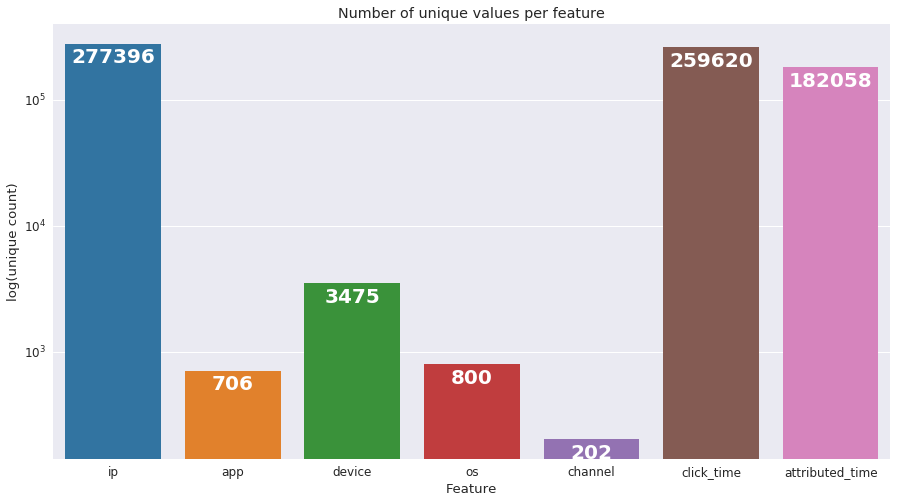

In [7]:
plt.figure(figsize=(15,8))
cols = ['ip', 'app', 'device', 'os', 'channel', 'click_time', 'attributed_time']
uniques = [len(df_train[col].unique()) for col in cols]
sns.set(font_scale=1.2)
ax = sns.barplot(cols, uniques, palette=pal, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature')

for patch, unique_num in zip(ax.patches, uniques):
    height = patch.get_height()
    ax.text(
        x=patch.get_x() + patch.get_width()/2,
        y=height*0.7,
        s=unique_num,
        ha="center",
        color='white',
        fontweight='bold',
        fontsize=20
    )

### 2.3 Feature당 가장 많이 나오는 Values

most_frequent_value_of_features: 0:00:17.924281


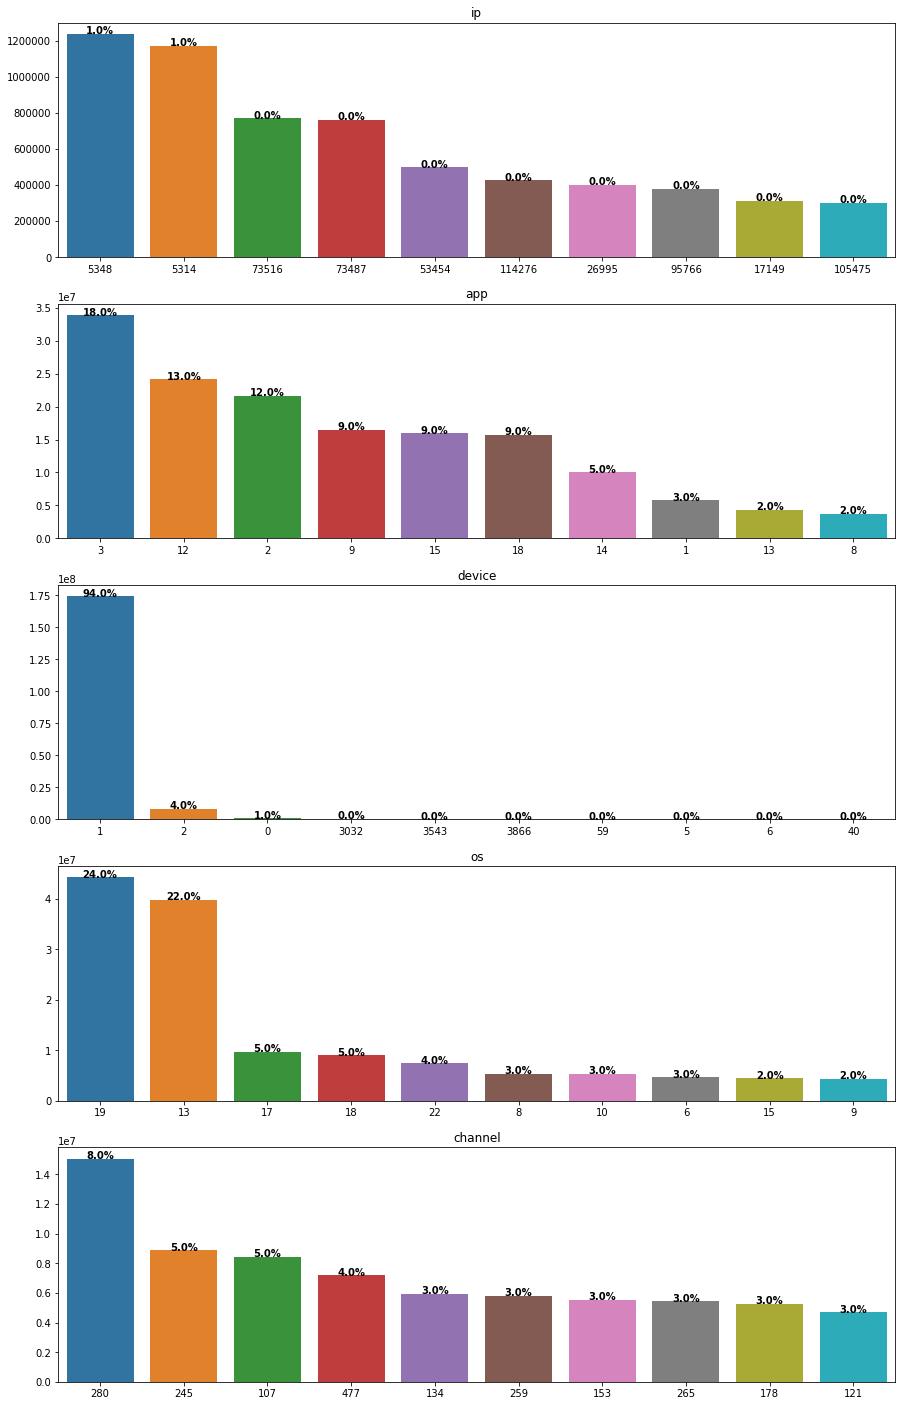

In [4]:
features = ['ip', 'app', 'device', 'os', 'channel']
fig, ax_arr = plt.subplots(len(features), 1, figsize=(15, 25))

@check_time
def most_frequent_value_of_features():
    for i, feature in enumerate(features):
        serial = df_train[feature].value_counts()[:10] 
        ax = ax_arr[i]

        sns.barplot(x=serial.axes[0], y=serial.get_values(), ax=ax, order=serial.axes[0])
        ax.set_title(feature)

        for patch, number in zip(ax.patches, serial.get_values()):
            _total =len(df_train)
            height = patch.get_height()
            ax.text(
                x=patch.get_x() + patch.get_width()/2,
                y=height-10,
                s="{}%".format(round(100*number/_total), 2),
                ha="center",
                fontweight='bold',
            )
    fig.show()
most_frequent_value_of_features()

In [41]:
### 2.4 Total Click vs Not download

### 2.5 불균형 문제

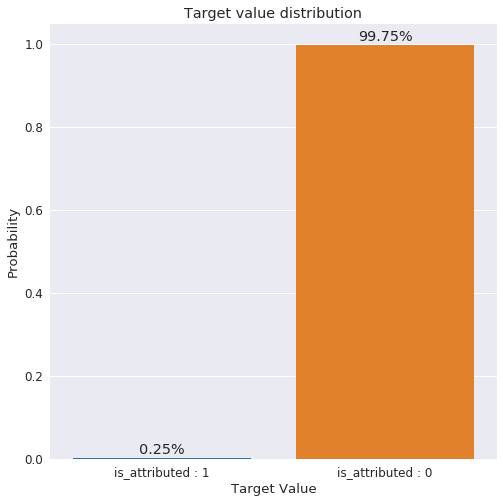

In [44]:
# 불균형 문제
# 0 : 99.75 %
# 1 : 0.25 %
plt.figure(figsize=(8, 8))
sns.set(font_scale=1.2)
mean = (df_train.is_attributed.values == 1).mean()
ax = sns.barplot(['is_attributed : 1', 'is_attributed : 0'], [mean, 1-mean], palette=pal)
ax.set(xlabel='Target Value', ylabel='Probability', title='Target value distribution')
for p, uniq in zip(ax.patches, [mean, 1-mean]):
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.,
            height + 0.01,
            '{}%'.format(round(uniq * 100, 2)),
            ha="center") 

## 3. 시간 패턴

In [4]:
# df_train['click_date'] = df_train.click_time.str[0:10]
df_train['click_hour'] = df_train.click_time.str[11:13]
# df_train['click_minute'] = df_train.click_time.str[14:16]
# df_train['click_sec'] = df_train.click_time.str[17:19]

<Figure size 1080x576 with 0 Axes>

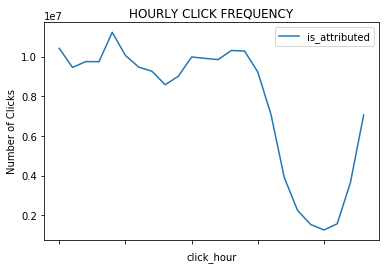

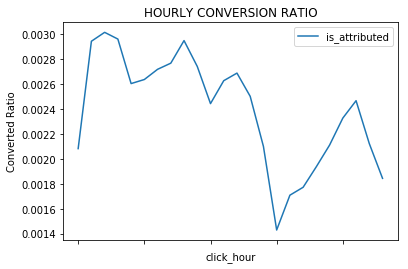

In [5]:
# plt size 
plt.figure(figsize=(15, 8))

# click frequency
df_train[['click_hour','is_attributed']].groupby(['click_hour'], as_index=True).count().plot()
plt.title('HOURLY CLICK FREQUENCY');
plt.ylabel('Number of Clicks');

# conversion ratio
df_train[['click_hour','is_attributed']].groupby(['click_hour'], as_index=True).mean().plot()
plt.title('HOURLY CONVERSION RATIO');
plt.ylabel('Converted Ratio');

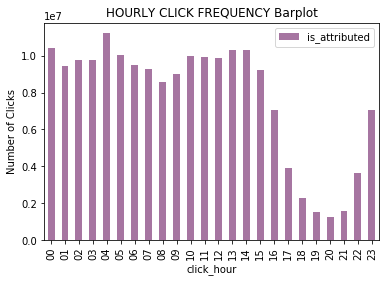

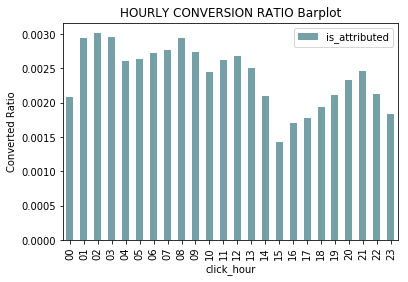

In [8]:
df_train[['click_hour','is_attributed']].groupby(['click_hour'], as_index=True).count().plot(kind='bar', color='#a675a1')
plt.title('HOURLY CLICK FREQUENCY Barplot');
plt.ylabel('Number of Clicks');

df_train[['click_hour','is_attributed']].groupby(['click_hour'], as_index=True).mean().plot(kind='bar', color='#75a1a6')
plt.title('HOURLY CONVERSION RATIO Barplot');
plt.ylabel('Converted Ratio');